In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import torch
from torchvision import transforms
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# load the dataset
ds = load_dataset("docmhvr/powerline-components-and-faults")

print(ds)

print(ds['train'][28])

# function to plot images with bounding boxes
def plot_image_with_bboxes(image, bboxes, labels, ax):
    ax.imshow(image)
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),  
            bbox[2] - bbox[0],  
            bbox[3] - bbox[1],  
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)


num_images_train = len(ds['train'])
print(f"Number of images in the training set: {num_images_train}")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['image', 'bboxes', 'labels'],
        num_rows: 1794
    })
    validation: Dataset({
        features: ['image', 'bboxes', 'labels'],
        num_rows: 77
    })
    test: Dataset({
        features: ['image', 'bboxes', 'labels'],
        num_rows: 41
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7F5757E39050>, 'bboxes': [[304.5, 131.5, 336.5, 536.5]], 'labels': [0]}
Number of images in the training set: 1794


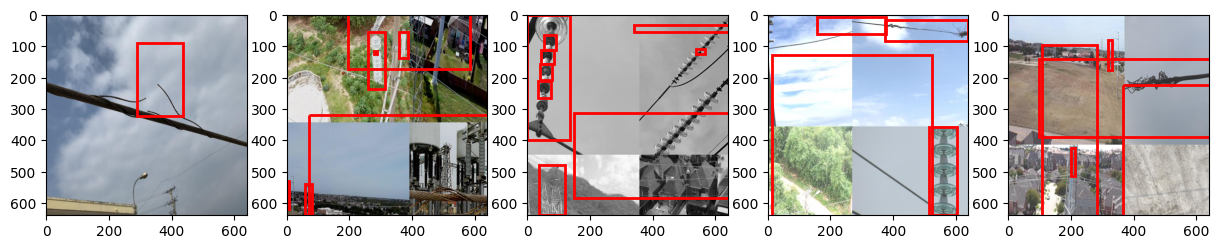

In [ ]:
# plotting the first 5 images with bounding boxes
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image = ds['train'][i]['image']
    bboxes = ds['train'][i]['bboxes']
    labels = ds['train'][i]['labels']
    plot_image_with_bboxes(image, bboxes, labels, axes[i])

plt.show()



In [ ]:
def filter_invalid_bboxes(target):
    #removing bounding boxes with zero width or height, does not work in training
    boxes = target["boxes"]
    valid_indices = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])  # x2 > x1 and y2 > y1
    target["boxes"] = boxes[valid_indices]
    target["labels"] = target["labels"][valid_indices]
    return target


In [ ]:
# define the transformation for images
transform = transforms.Compose([
    transforms.ToTensor(),  #image resizing
])

# process dataset for faster rcnn
def transform_fn(example):
    image = transform(example['image']) 
    target = {}
    target['boxes'] = torch.tensor(example['bboxes'], dtype=torch.float32)
    target['labels'] = torch.tensor(example['labels'], dtype=torch.int64)

    target = filter_invalid_bboxes(target)  

    return image, target


# transforming dataset
dataset = {
    'train': [(transform_fn(ds['train'][i])) for i in range(len(ds['train']))],
    'validation': [(transform_fn(ds['validation'][i])) for i in range(len(ds['validation']))],
    'test': [(transform_fn(ds['test'][i])) for i in range(len(ds['test']))],
}

image, target = dataset['train'][0]
print(f"Image shape: {image.shape}")
print(f"Bounding Boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")


Image shape: torch.Size([3, 640, 640])
Bounding Boxes: tensor([[289.9666,  88.1986, 435.8780, 321.6927]])
Labels: tensor([0])


In [ ]:
from torch.utils.data import Dataset, DataLoader

#custom dataset class for PyTorch
class PowerlineDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]  
#creating dataset objects
train_dataset = PowerlineDataset(dataset['train'])
val_dataset = PowerlineDataset(dataset['validation'])
test_dataset = PowerlineDataset(dataset['test'])

#defining a collate function for batching (since targets are dicts)
def collate_fn(batch):
    images, targets = zip(*batch)  #unzip batch into images and targets
    return list(images), list(targets)

#create and initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

#sample batch
images, targets = next(iter(train_loader))
print(f"Batch size: {len(images)}")
print(f"Image tensor shape: {images[0].shape}")
print(f"Bounding Boxes: {targets[0]['boxes']}")
print(f"Labels: {targets[0]['labels']}")


Batch size: 4
Image tensor shape: torch.Size([3, 640, 640])
Bounding Boxes: tensor([[  0.0000, 221.0000,  12.0000, 252.0000],
        [  0.0000,   0.0000,  26.0000, 313.0000],
        [225.0000,   0.0000, 256.0000, 242.0000],
        [  0.0000,   0.0000, 260.0000, 364.0000],
        [474.0000,  58.0599, 806.0000, 307.9213],
        [ -5.2236, 266.8049,   5.2236, 766.0728],
        [474.0000, 221.0411, 806.0000, 692.8962]])
Labels: tensor([1, 3, 3, 4, 0, 3, 0])


In [ ]:
#load faster rcnn model (pretrained on coco)
num_classes = len(set([label for _, target in dataset['train'] for label in target['labels']])) + 1  # Add 1 for background

import torchvision.models as models
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

model = models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
#model = torch.compile(model)

#modify classifier for dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Get number of input features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

#move model to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 112MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch.optim as optim

#faster rcnn optimizer definition
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 5 


training 10% dataset

In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
import random
from tqdm import tqdm  #for progress bar

random.seed(42)

#reduce dataset to 10%
def get_subset(dataset, percentage=0.1):
    num_samples = int(len(dataset) * percentage)
    indices = random.sample(range(len(dataset)), num_samples)
    return Subset(dataset, indices)

#collate function to handle different image sizes
def collate_fn(batch):
    images, targets = zip(*batch)  #unzip images and targets
    return list(images), list(targets)  #return as lists

# apply subest to dataset
train_subset = get_subset(train_dataset, percentage=0.1)
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, collate_fn=collate_fn)

def train_one_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    model.to(torch.float32)  #convert model weights to float32 bit
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, targets in loop:
        images = [img.to(device, dtype=torch.float32) for img in images]  #convert images to float32
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #forward pass
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        #update progress bar with current loss
        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

#training loop
for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss:.4f}")


Epoch 1/5: 100%|██████████| 23/23 [00:44<00:00,  1.93s/it, loss=0.807]


Epoch [1/5], Average Loss: 2.8673


Epoch 2/5: 100%|██████████| 23/23 [00:43<00:00,  1.90s/it, loss=0.905]


Epoch [2/5], Average Loss: 1.0312


Epoch 3/5: 100%|██████████| 23/23 [00:44<00:00,  1.94s/it, loss=0.522]


Epoch [3/5], Average Loss: 0.9230


Epoch 4/5: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it, loss=1.5]


Epoch [4/5], Average Loss: 0.8824


Epoch 5/5: 100%|██████████| 23/23 [00:44<00:00,  1.94s/it, loss=1.02]

Epoch [5/5], Average Loss: 0.8187


slower code , training full dataset, crashed ram

do not run this code block without a good GPU compute

In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
import random
from tqdm import tqdm  

random.seed(42)

def get_subset(dataset, percentage=0.1):
    num_samples = int(len(dataset) * percentage)
    indices = random.sample(range(len(dataset)), num_samples)
    return Subset(dataset, indices)

def collate_fn(batch):
    images, targets = zip(*batch)  # Unzip images and targets
    return list(images), list(targets)  # Return as lists

train_subset = get_subset(train_dataset, percentage=0.1)
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, collate_fn=collate_fn)

def train_one_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    model.to(torch.float32)  
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, targets in loop:
        images = [img.to(device, dtype=torch.float32) for img in images]  
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

#training loop
for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss:.4f}")


validation

In [ ]:
def validate_one_epoch(model, val_loader, device, epoch):
    model.eval()  #set model to evaluation mode
    total_loss = 0
    loop = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", leave=True)

    with torch.no_grad():  #disable gradient calculations
        for images, targets in loop:
            images = [img.to(device, dtype=torch.float32) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            #forward pass
            model.train()  #temporarily set to training mode to get loss
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            total_loss += loss.item()

            model.eval()  #switch back to eval mode after loss computation

            #update progress bar with current loss
            loop.set_postfix(val_loss=loss.item())

    return total_loss / len(val_loader)

#create validation dataset loader 
val_subset = get_subset(val_dataset, percentage=0.1)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, collate_fn=collate_fn)

#run validation separately
for epoch in range(num_epochs):
    val_loss = validate_one_epoch(model, val_loader, device, epoch)
    print(f"Validation Epoch [{epoch+1}/{num_epochs}], Average Val Loss: {val_loss:.4f}")


Validation 1/5: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, val_loss=1.5]


Validation Epoch [1/5], Average Val Loss: 1.4957


Validation 2/5: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, val_loss=1.48]


Validation Epoch [2/5], Average Val Loss: 1.4758


Validation 3/5: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, val_loss=1.46]


Validation Epoch [3/5], Average Val Loss: 1.4571


Validation 4/5: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, val_loss=1.48]


Validation Epoch [4/5], Average Val Loss: 1.4771


Validation 5/5: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, val_loss=1.48]

Validation Epoch [5/5], Average Val Loss: 1.4783


With a higher percentage of data being trained and more epochs, the loss can be further reduced.

In [16]:
torch.save(model.state_dict(), "faster_rcnn_powerlines.pth")
print("Model saved successfully!")


Model saved successfully!
